- Figure 4e : Normal OPC vs GFP(+) OPC
- Figure 4f : GFP (+) OPC vs GFP(+) Tumor
- Gene sets
  - GO : biological process
  - KEGG
  - REACTOME
  - MouseMine
- ORA -> GSEA

In [43]:
import os
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
import decoupler as dc

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import gseapy as gp

seed = 777

In [4]:
# create pseudobulk & replicates
# condition : columns in adata.obs

def do_pseudobulk(adata, condition, contrast = None, seed = seed):
    print("*** Don't forget to set reference value for each category ***\n")
    
    
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            if contrast:
                if pd.api.types.is_numeric_dtype(sample_cell_subset.obs[contrast]):
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].mean()
                else:
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    design_factors = [x for x in [contrast, 'condition', ] if x is not None]
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = design_factors,
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return pb, dds, de, fig

In [5]:
msigdb = dc.get_resource('MSigDB', organism = 'mouse')

In [4]:
collections = msigdb['collection'].unique()
for idx, collection in enumerate(collections, 1):
    print(f"{idx}. {collection}")

# hallmark
# kegg_pathways
# go_biological_process
# reactome_pathways

## additional
# oncogenic_signatures
# cell_type_signatures = annotation?
# cancer_modules

1. chemical_and_genetic_perturbations
2. immunesigdb
3. mirna_targets_mirdb
4. go_molecular_function
5. tf_targets_gtrf
6. tf_targets_legacy
7. oncogenic_signatures
8. cell_type_signatures
9. vaccine_response
10. go_biological_process
11. cancer_gene_neighborhoods
12. cancer_modules
13. go_cellular_component
14. wikipathways
15. reactome_pathways
16. hallmark
17. mirna_targets_legacy
18. biocarta_pathways
19. positional
20. human_phenotype_ontology
21. pid_pathways
22. kegg_pathways


In [6]:
query = 'hallmark'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

# 1. Fig 4e

In [26]:
adata = sc.read_h5ad('../output/annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['cell_type'] == 'OPC'].copy()
adata.obs['condition'] = adata.obs['sample_id'].apply(lambda x: 'Tumor' if x.startswith('Mouse') else 'Normal')
adata.obs.condition = adata.obs.condition.astype('category')
cond = ((adata.obs['GFP'] == 'GFP+') & (adata.obs.condition == 'Tumor')) | ((adata.obs['GFP'] == 'GFP-') & (adata.obs.condition == 'Normal'))
adata = adata[:, adata.var_names != 'Cas9-EGFP'].copy()
adata = adata[cond].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 11707 × 9828
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type', 'condition'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

*** Don't forget to set reference value for each category ***



Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.44 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 0.46 seconds.

Fitting LFCs...
... done in 0.37 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 10 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs Normal
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik    55.302777        0.341876  0.193605  1.765841  7.742259e-02   
0610009L18Rik    19.517299       -0.709890  0.259741 -2.733068  6.274741e-03   
0610010K14Rik    67.925037        0.761256  0.193821  3.927629  8.578746e-05   
0610030E20Rik    30.459702        0.201913  0.096025  2.102703  3.549175e-02   
0610040J01Rik   176.116651       -1.291759  0.172791 -7.475844  7.671002e-14   
...                    ...             ...       ...       ...           ...   
mt-Nd3          405.046624       -1.199495  0.311414 -3.851766  1.172692e-04   
mt-Nd4         2268.893728       -0.489758  0.210203 -2.329931  1.980978e-02   
mt-Nd4l         194.258931       -1.692991  0.212693 -7.959776  1.723506e-15   
mt-Nd5          264.731566       -0.454463  0.120184 -3.781386  1.559579e-04   
mt-Nd6           40.576377        0.004085  0.170815  0.

... done in 0.28 seconds.



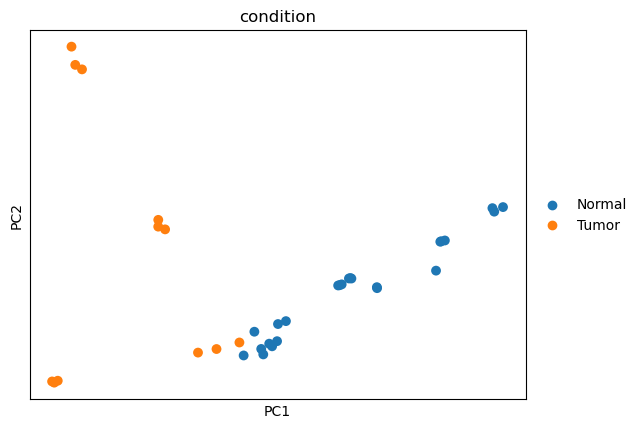

In [47]:
pb, dds, de, fig = do_pseudobulk(adata, 'condition')

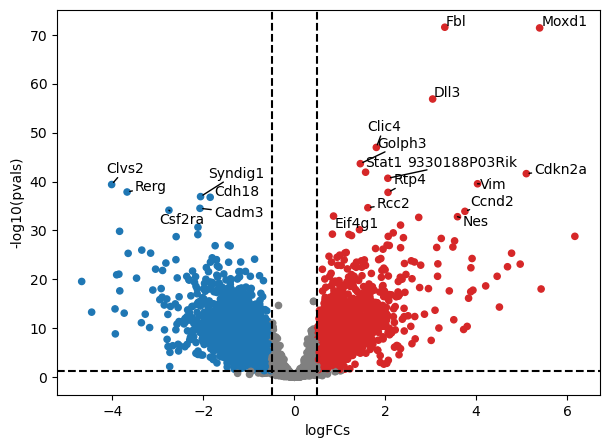

In [28]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20, )

## ORA

In [198]:
db['geneset'] = db['geneset'].apply(
    lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
)

In [30]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,171,0.491228,0.000004,0.000029,1.525286,18.928063,Abca1;Abcb8;Acadm;Acox1;Adipor2;Agpat3;Ak2;Ald...
1,ALLOGRAFT_REJECTION,174,0.229885,0.997705,0.999721,0.713476,0.001640,Abce1;Ache;Akt1;B2m;Bcat1;Bcl10;Ccnd2;Ccnd3;Cs...
2,ANDROGEN_RESPONSE,95,0.421053,0.030144,0.075360,1.308877,4.583382,Abhd2;Acsl3;Adamts1;Akap12;Akt1;Appbp2;B2m;Cam...
3,ANGIOGENESIS,33,0.121212,0.998235,0.999721,0.413569,0.000731,Ccnd2;Lrpap1;Pdgfa;Ptk2
4,APICAL_JUNCTION,163,0.374233,0.101374,0.202748,1.160739,2.656861,Actb;Actg1;Adam15;Adam23;Arpc2;Atp1a3;Baiap2;B...


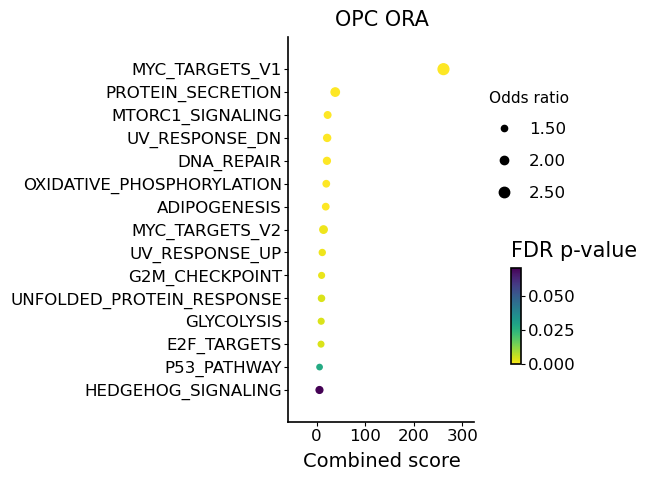

In [106]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
        title= "OPC ORA"
    )
    plt.grid(False)


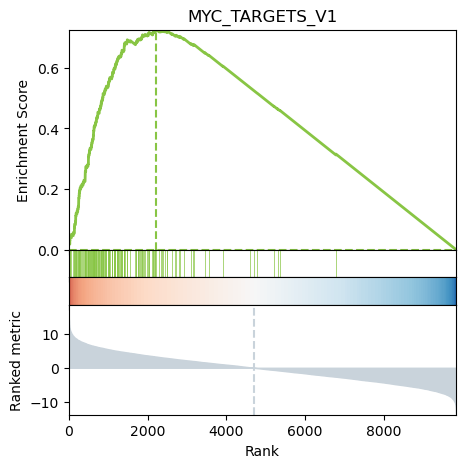

In [32]:
dc.plot_running_score(
    df=de,
    stat='stat',
    net=db,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)

## Progeny

In [33]:
progeny = dc.get_progeny(top=1000, organism = "mouse")
progeny

,source,target,weight,p_value
0,Androgen,Tmprss2,11.490631,0.000000e+00
1,Androgen,Nkx3-1,10.622551,2.242078e-44
2,Androgen,Mboat2,10.472733,4.624285e-44
3,Androgen,Sarg,11.386852,2.790209e-40
4,Androgen,Slc38a4,7.363805,1.253072e-39
...,...,...,...,...
13995,p53,Fanci,-3.962874,2.598821e-04
13996,p53,Ywhae,-1.924218,2.604428e-04
13997,p53,Elovl5,-1.287946,2.623710e-04
13998,p53,Naalad2,-1.035270,2.640760e-04


In [34]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

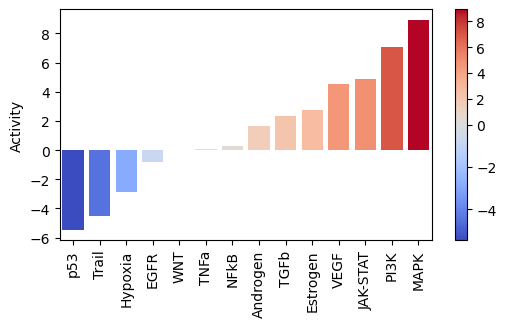

In [35]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

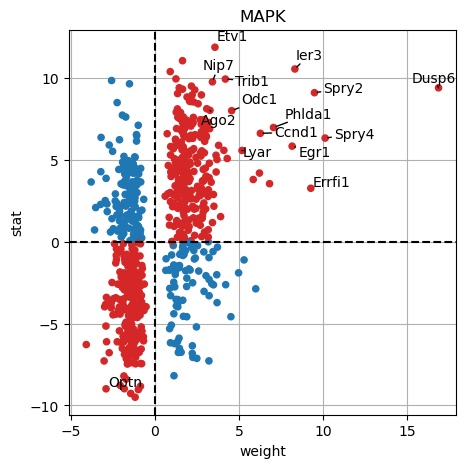

In [36]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='MAPK',
    net=progeny,
    top=15
)

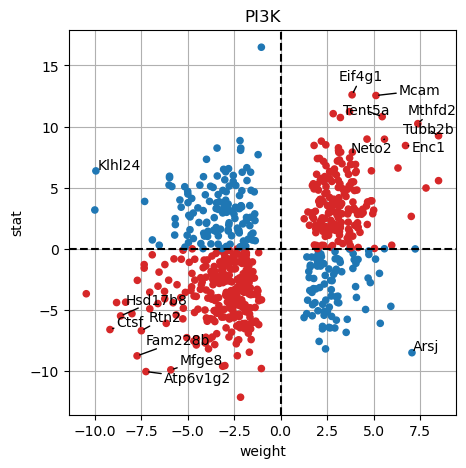

In [37]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='PI3K',
    net=progeny,
    top=15
)

## GSEA

In [50]:
de['rank'] = -np.log10(de.padj) * de.log2FoldChange
de = de.sort_values('rank', ascending=False)
de['gene'] = de.index

In [62]:
rnk = de[['gene', 'rank']].reset_index(drop=True).copy()

In [75]:
gene_sets = db[['geneset', 'genesymbol']].groupby('geneset').agg(lambda x: x.tolist()).to_dict()['genesymbol']
gene_sets = {k: v for k, v in gene_sets.items() if v}

In [76]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, seed = seed, threads=16, permutation_num=10000)

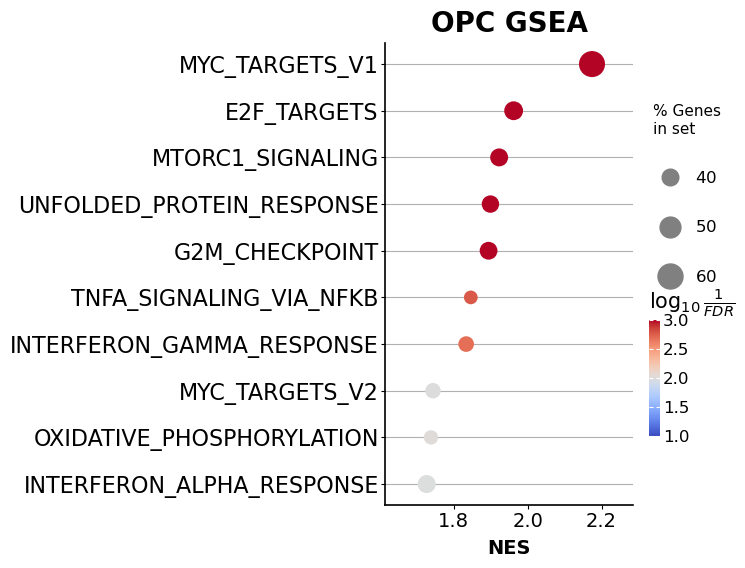

In [103]:
with mplscience.style_context():
    gp.dotplot(pre_res.res2d, column = 'FDR q-val', title = "OPC GSEA", cmap = 'coolwarm')

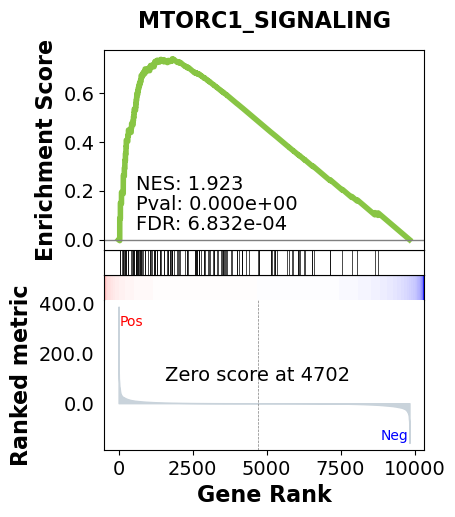

In [112]:
pre_res.plot(terms = pre_res.res2d.Term[2])
plt.show()
plt.close()

# 2. Fig 4f

In [190]:
def do_pseudobulk(adata, condition, reference, seed = seed):
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) 
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0).reshape(1,-1),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['condition'],
        ref_level=['condition' ,reference],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

In [114]:
adata = sc.read_h5ad('../output/8_annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['GFP'] == 'GFP+'].copy()
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'])].copy()
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])
adata = adata[:, adata.var_names != 'Cas9-EGFP'].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 10003 × 10875
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.45 seconds.

Fitting dispersion trend curve...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.48 seconds.

Fitting LFCs...
... done in 0.47 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs OPC
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik   299.700812       -0.095950  0.304933 -0.314658  7.530213e-01   
0610009L18Rik    52.969684       -0.124980  0.492693 -0.253666  7.997535e-01   
0610010K14Rik   487.001648        0.036791  0.153219  0.240117  8.102392e-01   
0610030E20Rik   173.282828       -0.153576  0.140681 -1.091664  2.749810e-01   
0610040J01Rik   409.548458       -0.954189  0.174466 -5.469203  4.520628e-08   
...                    ...             ...       ...       ...           ...   
mt-Nd3         1118.974370       -0.073914  0.179544 -0.411676  6.805772e-01   
mt-Nd4         9801.163520        0.095642  0.100153  0.954954  3.396012e-01   
mt-Nd4l         406.599002       -0.556270  0.347194 -1.602186  1.091145e-01   
mt-Nd5         1138.355507       -0.093056  0.162130 -0.573962  5.659938e-01   
mt-Nd6          217.078064       -0.758843  0.241063 -3.147

... done in 0.30 seconds.



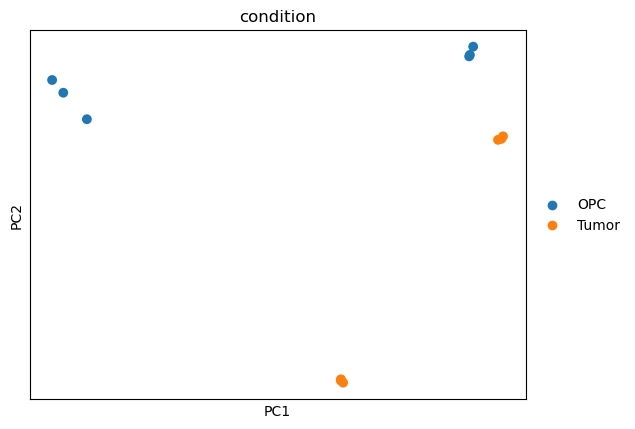

In [115]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

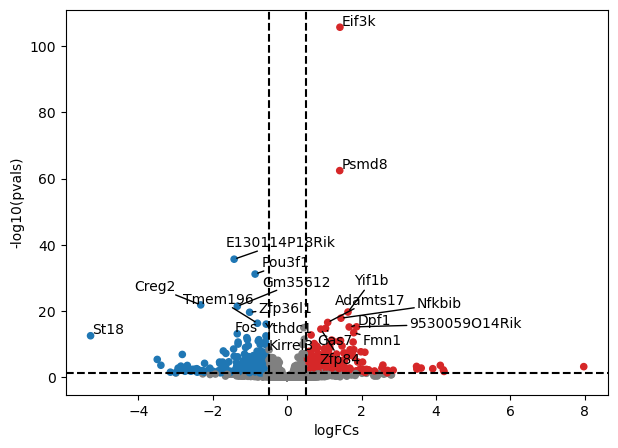

In [116]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

## ORA

In [117]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,171,0.152047,0.000236,0.002218,2.163102,18.065989,Apoe;Cd302;Cs;Cyc1;Dgat1;Dlat;Dnajb9;Ech1;Etfb...
1,ALLOGRAFT_REJECTION,174,0.063218,0.717358,0.842896,0.912761,0.303201,B2m;Bcat1;Bcl3;Csk;Eif3d;Eif3j1;Eif5a;H2-D1;H2...
2,ANDROGEN_RESPONSE,95,0.168421,0.001188,0.009309,2.410915,16.237943,Abcc4;Adrm1;Appbp2;B2m;Camkk2;Dnajb9;Ell2;Elov...
3,APICAL_JUNCTION,163,0.116564,0.025900,0.067627,1.662059,6.072377,Actb;Bmp1;Cldn11;Col16a1;Fbn1;Gnai1;Insig1;Jam...
4,APOPTOSIS,145,0.137931,0.003822,0.016331,1.966615,10.948087,Bnip3l;Casp1;Cav1;Ctnnb1;Cyld;Ddit3;Dnajc3;Emp...


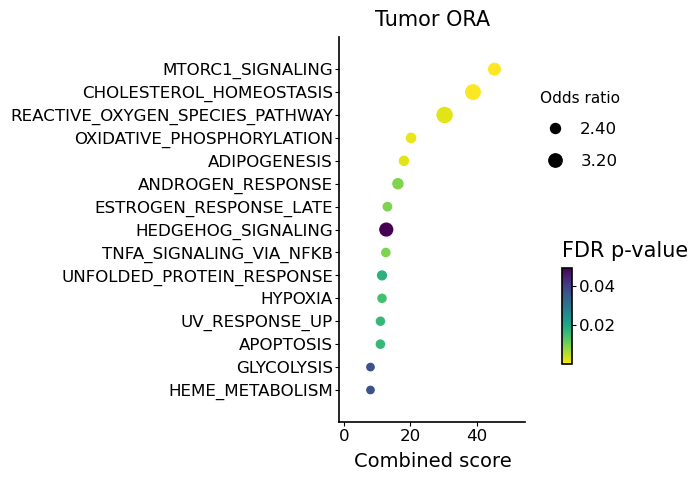

In [118]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
        title= "Tumor ORA"
    )
    plt.grid(False)


## Progeny

In [119]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

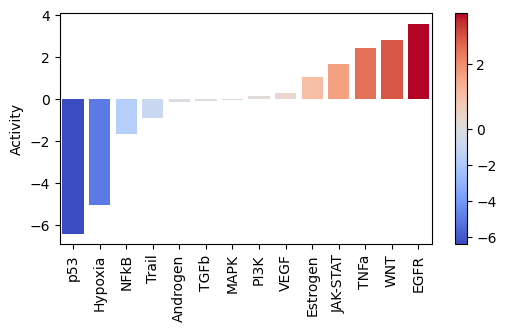

In [120]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

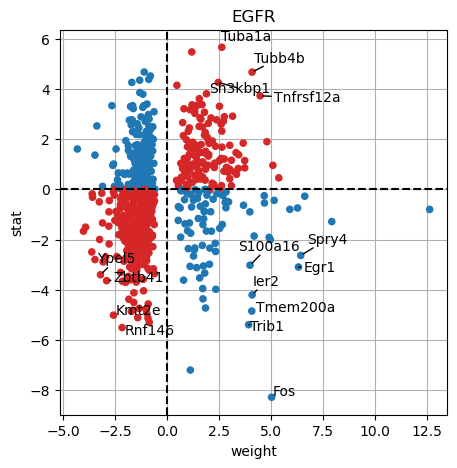

In [121]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='EGFR',
    net=progeny,
    top=15
)

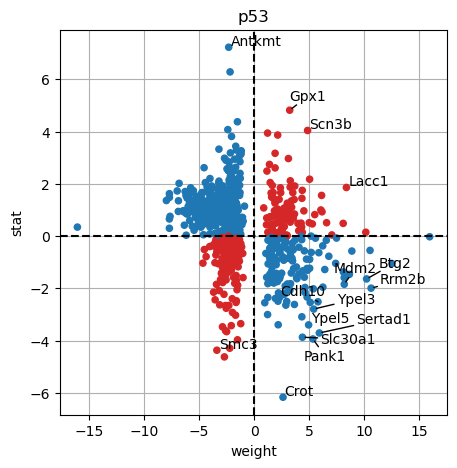

In [122]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='p53',
    net=progeny,
    top=15
)

## GSEA
- hallmark, go_biological_process, kegg_pathways, reactome_pathways, oncogenic_signatures : no significant

In [195]:
query = 'hallmark'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

In [181]:
de['rank'] = -np.log10(de.padj) * de.log2FoldChange
de = de.sort_values('rank', ascending=False)
de['gene'] = de.index

In [182]:
rnk = de[['gene', 'rank']].reset_index(drop=True).copy()

In [183]:
gene_sets = db[['geneset', 'genesymbol']].groupby('geneset').agg(lambda x: x.tolist()).to_dict()['genesymbol']
gene_sets = {k: v for k, v in gene_sets.items() if v}

In [184]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, seed = seed, threads=16, permutation_num=10000)

In [188]:
with mplscience.style_context():
    gp.dotplot(pre_res.res2d, column = 'FDR q-val', title = "Tumor GSEA", cmap = 'coolwarm')

ValueError: Warning: No enrich terms when cutoff = 0.05

# 2 - 2. Fig 4f : OPC vs Tumor (in mouse)

In [191]:
adata = sc.read_h5ad('../output/8_annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'])].copy()
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])
adata = adata[:, adata.var_names != 'Cas9-EGFP'].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 17643 × 10593
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.42 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 0.50 seconds.

Fitting LFCs...
... done in 0.28 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs OPC
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik    556.939254       -0.180316  0.290495 -0.620720  5.347840e-01   
0610010K14Rik    880.947005        0.057168  0.126959  0.450288  6.525025e-01   
0610030E20Rik    310.330215       -0.160900  0.123697 -1.300759  1.933409e-01   
0610040J01Rik    688.695489       -0.887615  0.137246 -6.467328  9.975100e-11   
1110002L01Rik    146.274345        0.089859  0.189288  0.474719  6.349869e-01   
...                     ...             ...       ...       ...           ...   
mt-Nd3          2071.439571       -0.129640  0.156499 -0.828376  4.074579e-01   
mt-Nd4         17841.764882        0.062044  0.061243  1.013079  3.110227e-01   
mt-Nd4l          732.255796       -0.567646  0.329900 -1.720663  8.531198e-02   
mt-Nd5          2009.884262       -0.086697  0.126109 -0.687474  4.917839e-01   
mt-Nd6           363.812465       -0.725150  0.2

... done in 0.28 seconds.



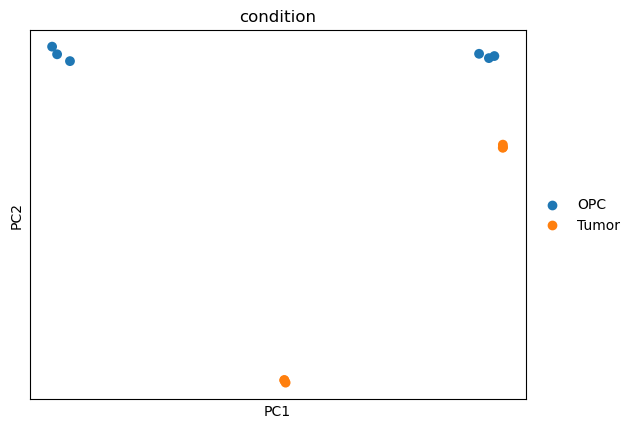

In [192]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

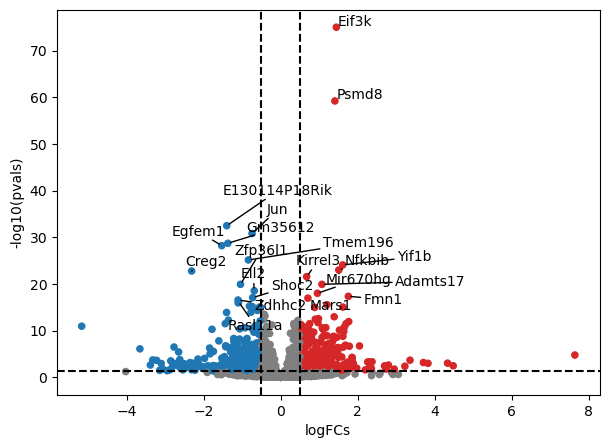

In [194]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

## ORA

In [199]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,171,0.233918,7.698350e-07,0.000018,2.282607,32.132463,Acaa2;Acox1;Ak2;Apoe;Cat;Cd302;Cs;Cyc1;Dbt;Dec...
1,ALLOGRAFT_REJECTION,174,0.080460,8.815267e-01,0.963529,0.793008,0.099998,B2m;Bcat1;Bcl3;Csk;Eif3d;Eif3j1;Eif5a;Ets1;Glm...
2,ANDROGEN_RESPONSE,95,0.221053,6.871452e-04,0.005622,2.164377,15.763083,Abcc4;Adrm1;Appbp2;Arid5b;B2m;Camkk2;Dnajb9;El...
3,APICAL_JUNCTION,163,0.134969,1.274824e-01,0.205051,1.319126,2.717105,Actb;Bmp1;Cap1;Cldn11;Col16a1;Evl;Fbn1;Gnai1;I...
4,APOPTOSIS,145,0.193103,9.956954e-04,0.006685,1.884769,13.027656,Bcap31;Bnip3l;Cav1;Cdc25b;Ctnnb1;Cyld;Ddit3;Dn...


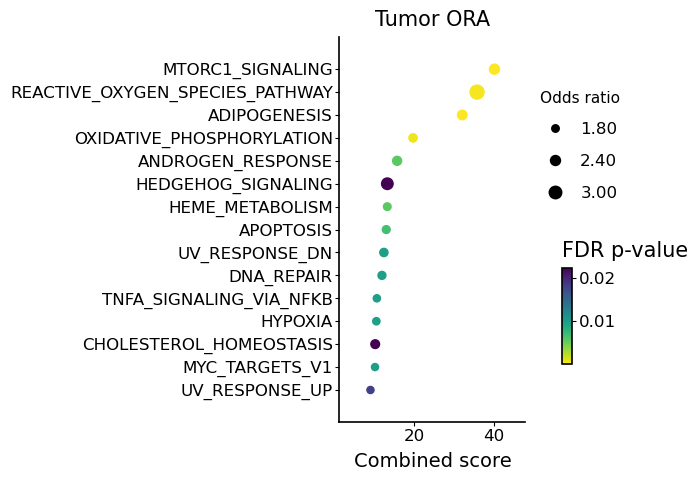

In [200]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
        title= "Tumor ORA"
    )
    plt.grid(False)


## Progeny

In [201]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

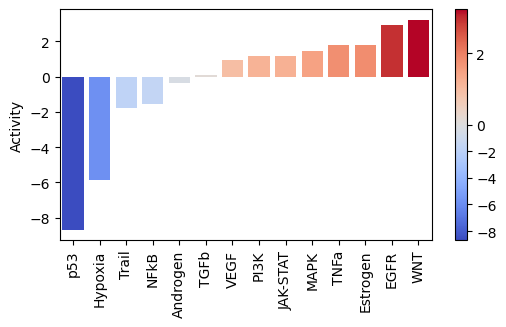

In [202]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

## GSEA

In [208]:
query = 'go_biological_process'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

In [209]:
de['rank'] = -np.log10(de.padj) * de.log2FoldChange
de = de.sort_values('rank', ascending=False)
de['gene'] = de.index

In [210]:
rnk = de[['gene', 'rank']].reset_index(drop=True).copy()

In [211]:
gene_sets = db[['geneset', 'genesymbol']].groupby('geneset').agg(lambda x: x.tolist()).to_dict()['genesymbol']
gene_sets = {k: v for k, v in gene_sets.items() if v}

In [212]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, seed = seed, threads=16, permutation_num=10000)

In [213]:
with mplscience.style_context():
    gp.dotplot(pre_res.res2d, column = 'FDR q-val', title = "Tumor GSEA", cmap = 'coolwarm')

ValueError: Warning: No enrich terms when cutoff = 0.05